In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
csv_path = "GFP.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)

# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [3]:
data.head()

,Open,High,Low,Close
Date,,,,
2009-04-24,905.50,915.40,904.20,914.10
2009-04-27,915.00,919.70,905.80,908.20
2009-04-28,907.20,907.70,884.60,893.60
2009-04-29,894.00,904.00,888.30,900.50
2009-04-30,898.60,900.80,880.10,891.20


In [8]:
data['Close']=data['Close'].replace(',','',regex=True)
data['Close']=pd.to_numeric(data['Close'],errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)

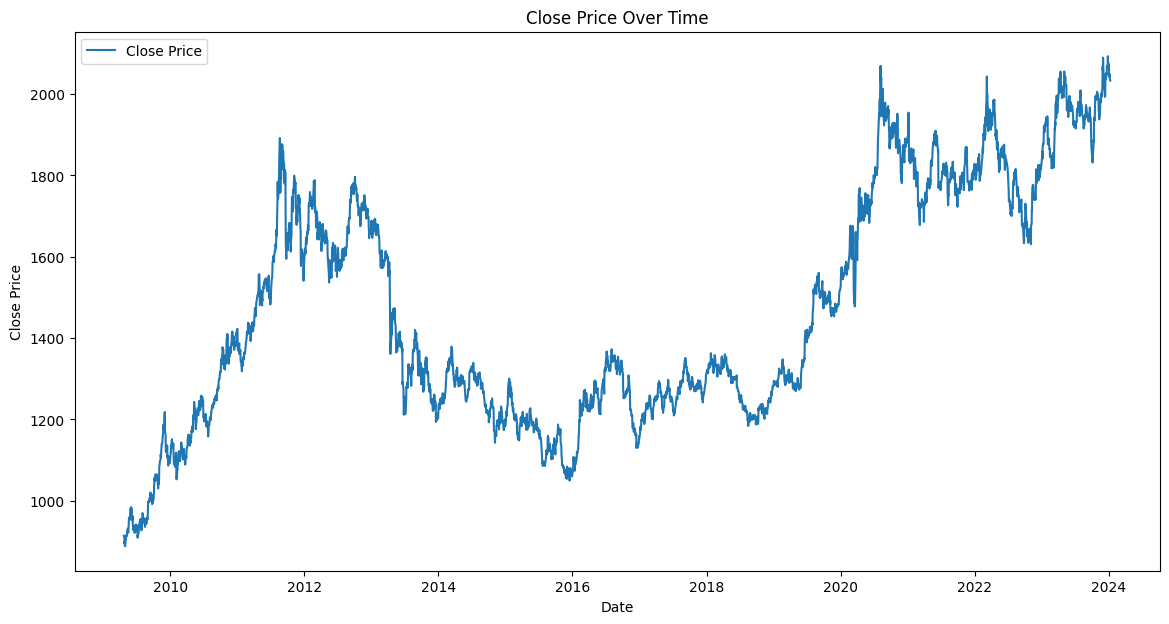

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(data.index,data['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

result_original = adfuller(data['Close'])

print(f'ADF Statistic (Original): {result_original[0]:.4f}')
print(f'p-value (Original): {result_original[1]:.4f}')

if result_original[1] < 0.05:
    print('The model is stationary')
else:
    print("The model isn\'t stationary")


data['close_diff'] = data['Close'].diff()

result_diff = adfuller(data['close_diff'].dropna())

print(f'ADF Statistic (Differenced): {result_diff[0]:.4f}')
print(f'p-value (Differenced): {result_diff[1]:.4f}')

if result_diff[1] < 0.05:
    print('The differenced series is stationary')
else:
    print("The differenced series isn't stationary")


ADF Statistic (Original): -1.4666
p-value (Original): 0.5499
The model isn't stationary
ADF Statistic (Differenced): -19.0649
p-value (Differenced): 0.0000
The differenced series is stationary


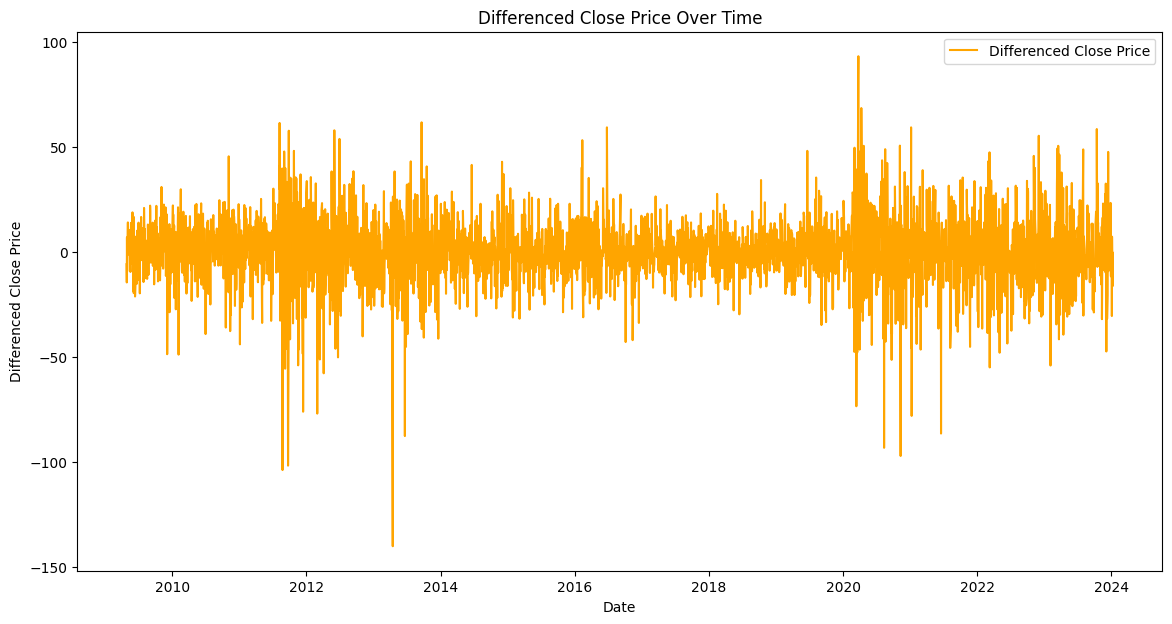

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close_diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

## ACF and PACF

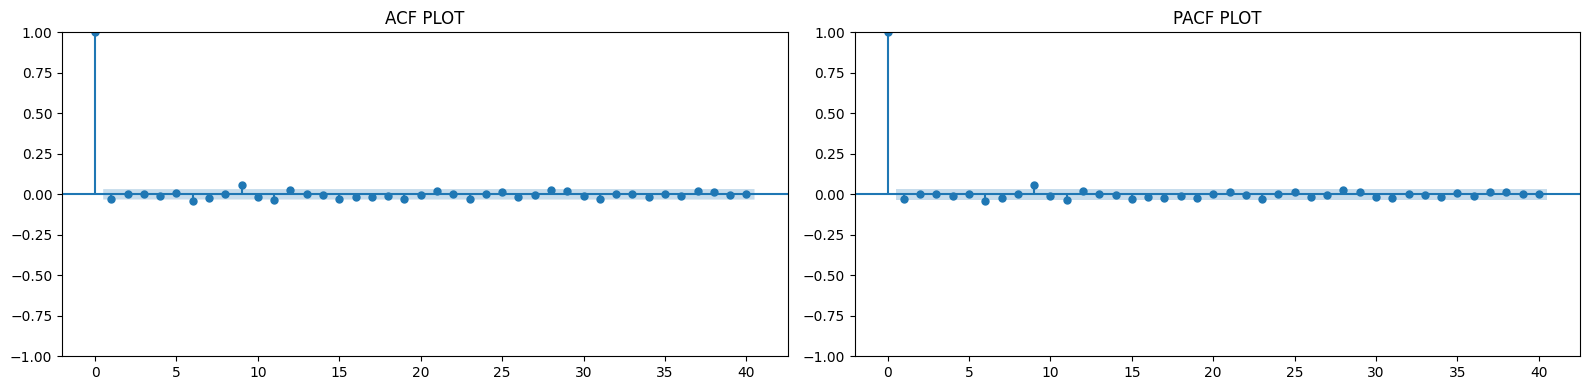

In [23]:
fig, axes=plt.subplots(1,2,figsize=(16, 4))
plot_acf(data['close_diff'].dropna(),lags=40,ax=axes[0])
axes[0].set_title('ACF PLOT')

plot_pacf(data['close_diff'].dropna(),lags=40,ax=axes[1])
axes[1].set_title('PACF PLOT')

plt.tight_layout()
plt.show()

In [31]:
model = auto_arima(data['Close'],
                   seasonal=False,
                   trace=True,
                   stepwise=True,
                   suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=30767.219, Time=5.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30766.676, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30764.942, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30764.960, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30766.097, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30766.929, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30766.930, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30765.943, Time=1.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30764.456, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=30766.436, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=30766.439, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30764.478, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=30766.094, Time=0.72 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 10.644 seconds


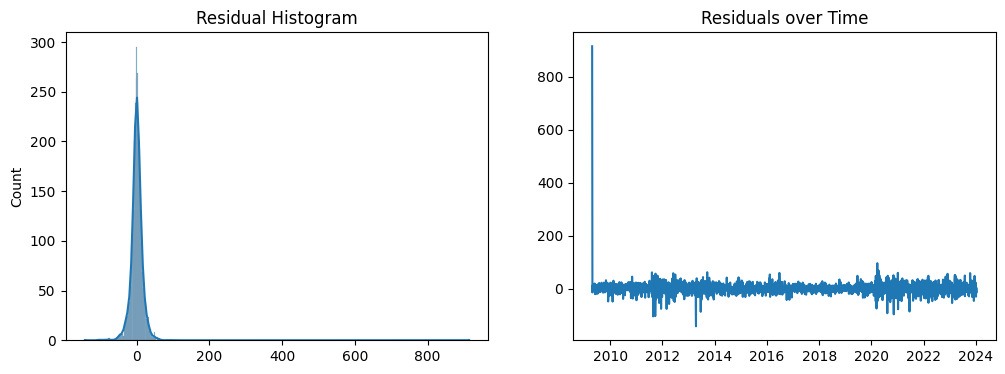

In [32]:
import seaborn as sns

residuals = model.resid()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True)
plt.title('Residual Histogram')

plt.subplot(1,2,2)
plt.plot(residuals)
plt.title('Residuals over Time')
plt.show()


In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


     lb_stat  lb_pvalue
10  5.955999   0.818946


## Modelling

In [38]:
cut_off=int(len(data)*0.8)

In [47]:
train_set=data.iloc[:cut_off]
test_set=data.iloc[cut_off:]

model=ARIMA(train_set['Close'],order=(1,1,0))
model_fit=model.fit()

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


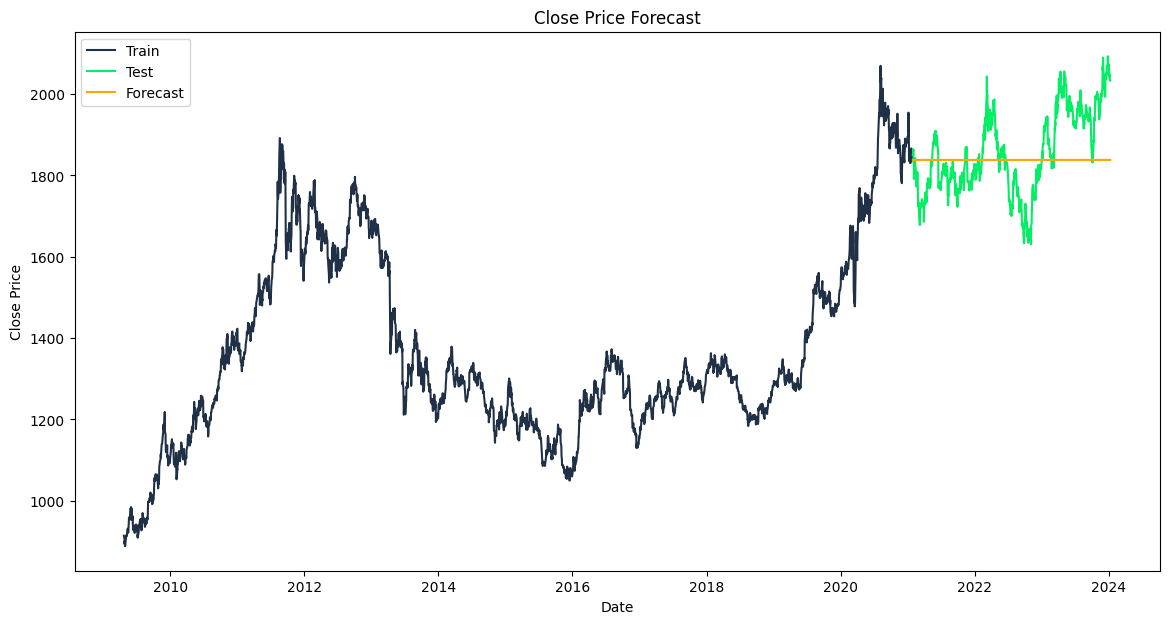

In [48]:

forecast = model_fit.forecast(steps=len(test_set))

plt.figure(figsize=(14,7))
plt.plot(train_set.index, train_set["Close"], label='Train', color='#203147')
plt.plot(test_set.index, test_set["Close"], label='Test', color='#01ef63')
plt.plot(test_set.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [49]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24449.284381878344
BIC: 24461.270946534547


In [51]:
forecast=forecast[:len(test_set)]
test_close=test_set['Close'][:len(forecast)]

rmse=np.sqrt(mean_squared_error(test_close,forecast))
print(f'RMSE{rmse:.2f}')

RMSE103.00
